# FastText

<br>

- **Word2Vec의 확장**으로 볼 수 있음.
- 차이점? Word2Vec은 단어를 쪼개질 수 없는 단위로 생각하는 반면, **FastText는 하나의 단어 안에도 여러 단어들이 존재하는 것으로 간주.**
    - **내부 단어 (subword)를 고려**해 학습.

## 내부 단어(subword)의 학습

<br>

- FastText에선 **각 단어를 글자 단위 n-gram의 구성으로 취급.**
    - n을 몇으로 결정하는지에 따라 단어들이 얼마나 분리되는지 결정됨.
    - ***시작과 끝을 의미하는 <, > 를 도입.*** 예시를 보자.

```{.python}
# apple에 대해 n = 3인 경우, 단어 분리 후 벡터 생성
<ap, app, ppl, ple, le>
```
- 추가적으로 **기존 단어에 <, >를 붙인 토큰을 하나 더 벡터화** 함. **특별 토큰**.
```{.python}
# 특별토큰
<apple>
```
- 즉, n=3인 경우 FastText는 *단어 apple에 대해 5개의 일반 토큰과 1개의 특별 토큰을 벡터화* 한다.
```{.python}
<ap, app, ppl, ple, le>, <apple>
```

<br>

- 실 사용시엔 n의 최소값과 최대값으로 범위를 설정할 수 있음. default는 3,6.
    - 최소값 = 3, 최대값 = 6인 경우, apple에 대해 FastText는 다음과 같은 단어들을 벡터화 한다.
    ```{.python}
    # n = 3 ~ 6 인 경우
    <ap, app, ppl, ppl, le>, <app, appl, pple, ple>, <appl, pple>, ... , <apple>
    ```
    - **내부 단어를 벡터화 한다는 의미는 이 단어들에 대해 Word2Vec을 수행한다**는 의미.
    - 내부 단어들의 벡터값을 얻었다면, apple의 벡터값은 위의 **벡터값들의 총 합**으로 구성.
    ```{.python}
    apple = <ap + app + ppl + ppl + le> + <app + appl + , ..., +<apple> 
    ```
- 이런 방법은 Word2Vec에선 가질 수 없었던 강점을 가지게 됨.

## 모르는 단어(Out Of Vocabulary, OOV)에 대한 대응

<br>

- FastText의 신경망을 학습한 후엔, 데이터 셋의 모든 단어의 각 n-gram에 대해 워드 임베딩이 진행됨.
- Word2Vec(and GloVe)에 비해 생기는 강점이 뭘까?
    - 데이터 셋만 충분하다면, **내부단어를 통해 모르는 단어에 대해서도 다른 단어와의 유사도 계산이 가능.**
    - birthplace라는 단어를 학습하지 않은 상태라고 해보자.
    - 다른 단어에서 ***birth와 place라는 내부 단어***가 있다면,
    - FastText는 **birthplace의 벡터를 얻을 수 있다.**

## 단어 집합 내 빈도수가 적었던 단어(Rare Word)에 대한 대응

<br>

- Word2Vec은 등장 빈도수가 적은 단어에 대해서 임베딩 정확도가 높지 않았었음.
    - **참고할 수 있는 경우의 수가 적다보니 정확하게 임베딩이 되지 않았던 것.**
- FastText는 **단어가 희귀 단어라도, 그 단어의 n-gram이 다른 단어의 n-gram과 겹치는 경우**라면
- Word2Vec과 비교했을 때 **비교적 높은 임베딩 벡터 값을 얻을 수 있음.**

<br>

- 이런 점 때문에 FastText는 **노이즈가 많은 말뭉치에서 강점**을 갖게 됨.
- 실제 많은 비정형 데이터엔 오타나 맞춤법이 틀린 단어가 많이 섞여있음.
    - ***이런 단어들은 당연히 등장 빈도수가 매우 적음.*** 일종의 희귀 단어.
    - Word2Vec에서 이런 단어는 임베딩이 제대로 안됐지만, FastText는 일정 수준의 성능을 보여줌.

## Word2Vec vs. FastText 간단 비교

<br>

- 이전에 썼던 ted xml파일 그대로 사용. 다시 코드 쓰자 ㅠ

In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from lxml import etree
import warnings

warnings.filterwarnings(action='ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Cheol Hee
[nltk_data]     Kim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
targetText = etree.parse(targetXML)

# context block 내용만 추출,
# regex써서 괄호 배경음 부분 제거.
parseText = '\n'.join(targetText.xpath('//content/text()'))
contentText = re.sub(r'\([^)]*\)', '', parseText)

# 입력 corpus에 대해 NLTK를 통해 문장 토큰화 진행 (불용어 제거)
sentText = sent_tokenize(contentText)

# 구두점 제거, 대문자->소문자 변환.
normalizedText = []
for text in sentText:
    tokens = re.sub(r"^a-z0-9", " ", text.lower())
    normalizedText.append(tokens)
    
# 각 문장 토큰화 진행
result = [word_tokenize(sentence) for sentence in normalizedText]

print('총 샘플 수 : {}'.format(len(result)))

총 샘플 수 : 273424


### Word2Vec Model

In [4]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences = result,
    vector_size = 100,
    window = 5,
    min_count = 5,
    workers = 4,
    sg = 0
)

In [5]:
model.wv.most_similar('electrofishing')

KeyError: "Key 'electrofishing' not present"

    단어 집합에 electrofishing이 없다고 함.
    Word2Vec은 학습 데이터에 존재하지 않는 단어(모르는 단어)에 대해선
    임베딩 벡터가 존재하지 않으므로 유사도 계산이 안됨.

### FastText

<br>

- Word2Vec 학습 코드만 FastText로 변경해 실행해보자.

In [6]:
from gensim.models import FastText

model = FastText(
    result,
    vector_size = 100,
    window = 5,
    min_count = 5,
    workers = 4,
    sg = 1
)

In [7]:
model.wv.most_similar('electrofishing')

[('electrolux', 0.8584972023963928),
 ('electrolyte', 0.8558030724525452),
 ('electroshock', 0.8482690453529358),
 ('electroencephalogram', 0.8378998637199402),
 ('airbag', 0.8358634114265442),
 ('electric', 0.8316196799278259),
 ('airbus', 0.8284210562705994),
 ('electrogram', 0.8203827738761902),
 ('electron', 0.8109163641929626),
 ('electrode', 0.8094940185546875)]

    Word2Vec과는 다르게
    학습하지 않은 단어에 대해 유사한 단어를 계산해 출력하고 있음.

## FastText in Korean

<br>

- 한국어에서도 마찬가지로 OOV 문제를 해결하기 위해 FastText를 적용하고자 했었음.

<br>

1. 음절 단위
    - 음절 단위 임베딩은 영단어와 거의 똑같음.
2. 자모 단위
    - 자모 단위(초성, 중성, 종성 단위)로 임베딩.
    - 오타나 노이즈 측면에서 더 강한 임베딩을 기대해 볼 수 있음.
    - '자연어처리' 를 다음과 같이 분리할 수 있음.

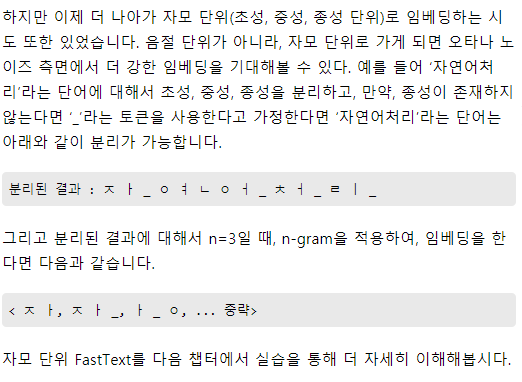

<br>

- 한국어의 경우 Word2Vec 모델의 효과가 더 좋다는 사례가 많음.
- 적절히 사용해보고 Word2Vec, GloVe, FastText 중에서 골라보는게 좋을 것.

### Example

<br>

- 네이버 신문기사 - 탈레반 (2021-08-18) 관련 기사 가져왔음.

#### 문장 단위 Split

In [2]:
def make_corpus(input_file, output_file):
    txt_file = open(output_file, 'w', encoding='UTF-8')
    
    with open(input_file, 'r', encoding='UTF-8') as f:
        text = f.readlines()
        num = 0
        
        for i in range(0, len(text)):
            sentence_list = text[i].strip()
            sentence = sentence_list.split('.')
            
            for j in range(0, len(sentence)):
                if len(sentence[j].strip()) > 3:
                    last_sentence = sentence[j].strip()
                    print(last_sentence)
                    txt_file.write(last_sentence + '\n')
                    num ++ 1
        print(num)
make_corpus('han.txt', 'corpus.txt')

탈레반은 누구인가
"1994년 아프간 남부 칸다하르에서 물라 무함마드 오마르에 의해 창설됐다
1989년 소련의 아프간 철수 이후 군벌 간 내전이 격화되자 오마르는 이슬람 전통 교육기관(마드라사) 출신 학생들을 주축으로 설립돼, 명칭(탈레반)도 파슈토어 '학생'에서 따왔다
1996년 아프간 정권을 장악한 탈레반은 '이슬람 이상 국가 건설'이 목표다
이슬람법인 샤리아에 따라 국가를 통치하는데 여성 인권을 탄압하는 것으로 악명이 높다
전광석화로 아프간 전역 장악한 탈레반, 지지자가 많나
"그렇지는 않다
탈레반이 수도 카불까지 사실상 무혈입성할 수 있었던 배경에는 오히려 아프간 정부의 부정부패와 무능이 자리한다
부패한 정부에서 월급도 제대로 못받는데다가 비전도 없는 정부를 위해 목숨 걸고 싸울 경찰과 군인은 없다
아슈라프 가니 아프간 대통령을 포함해 정부 고위 인사들이 탈레반에 맞서 싸우기보다 누구보다 빠르게 국외로 도피한 현실이 그들의 부족한 통치 능력과 의지를 보여준다
이런 아프간 정부의 무능·부패를 미국은 몰랐나
"알고 있었지만 그래도 이렇게 빠르게 무너질 것으로 예상하지 못했다
미국의 아프간 주두군 철수는 사실 시간의 문제였다
도널드 트럼프 전 행정부 시절부터 추진했고 더는 막대한 예산과 병력을 투입해도 상황이 개선되지 않을 거라는 판단을 이미 내렸다
20년 동안 2조2,600억 달러(2,600조 원)를 쏟아부었고 2,400명이 넘는 자국군이 목숨을 잃었기 때문이다
다만 동맹인 북대서양조약기구(NATO·나토)와 함께 아프간 정부군을 훈련시켰기 때문에 몇 개월은 버틸 것이라고 기대했던 게 오판이 됐다
불신이 팽배한 사회에서 여론을 정확히 파악하는 것은 사실상 불가능했고 일종의 '티핑포인트(급변점)'가 지나면서 폭발적인 속도로 정부가 무너져 내렸다
탈레반에 대한 아프간 내 저항은 이제 끝인가
"당장은 빠르게 투항한 세력들이 조만간 저항할 가능성이 충분히 있다
특히 미국이 아프간에 왔을 때 군사적 지원을 하고 아프간 정부의 요직들도 차지했던 북부동맹이 전투에 나설 

In [11]:
myFile = open('corpus.txt', 'r', encoding='UTF-8')
myFile = myFile.readlines()
myFile[:3]

['탈레반은 누구인가\n',
 '"1994년 아프간 남부 칸다하르에서 물라 무함마드 오마르에 의해 창설됐다\n',
 "1989년 소련의 아프간 철수 이후 군벌 간 내전이 격화되자 오마르는 이슬람 전통 교육기관(마드라사) 출신 학생들을 주축으로 설립돼, 명칭(탈레반)도 파슈토어 '학생'에서 따왔다\n"]

In [12]:
"""
# '' 랑 \n, ""를 지우자.
import re

def clean_text(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation 
        review = re.sub(r'\d+','', str(texts[i]))# remove number 
        review = review.lower() #lower case 
        review = re.sub(r'\s+', ' ', review) #remove extra space 
        review = re.sub(r'<[^>]+>','',review) #remove Html tags 
        review = re.sub(r'\s+', ' ', review) #remove spaces 
        review = re.sub(r"^\s+", '', review) #remove space from start 
        review = re.sub(r'\s+$', '', review) #remove space from the end 
        corpus.append(review) 
    return corpus
"""
# 상관 없나?

'\n# \'\' 랑 \n, ""를 지우자.\nimport re\n\ndef clean_text(texts): \n    corpus = [] \n    for i in range(0, len(texts)): \n        review = re.sub(r\'[@%\\*=()/~#&\\+á?Ã¡\\-\\|\\.\\:\\;\\!\\-\\,\\_\\~\\$\'"]\', \'\',str(texts[i])) #remove punctuation \n        review = re.sub(r\'\\d+\',\'\', str(texts[i]))# remove number \n        review = review.lower() #lower case \n        review = re.sub(r\'\\s+\', \' \', review) #remove extra space \n        review = re.sub(r\'<[^>]+>\',\'\',review) #remove Html tags \n        review = re.sub(r\'\\s+\', \' \', review) #remove spaces \n        review = re.sub(r"^\\s+", \'\', review) #remove space from start \n        review = re.sub(r\'\\s+$\', \'\', review) #remove space from the end \n        corpus.append(review) \n    return corpus\n'

#### 토큰 단위 분리

In [15]:
import json
from konlpy.tag import Okt

def make_token(input_file, output_file):
    okt = Okt()
    token_text_file = open(output_file, 'w', encoding='UTF-8')
    myList = []
    
    with open(input_file, 'r', encoding='UTF-8') as f:
        text = f.readlines()
        num = 0
        
        for i in range(0, len(text)):
            sentence = text[i].strip()
            morphs = okt.morphs(sentence)
            print(morphs)
            myList.append(morphs)
        print(num)
        
        jsonString = json.dumps(myList, ensure_ascii=False)
        token_text_file.write(jsonString)

make_token('corpus.txt', 'corpus_token.txt')

['탈레반', '은', '누구', '인가']
['"', '1994년', '아프간', '남부', '칸다하르', '에서', '물라', '무함마드', '오마르', '에', '의해', '창설', '됐다']
['1989년', '소련', '의', '아프간', '철수', '이후', '군벌', '간', '내전', '이', '격', '화', '되자', '오마르', '는', '이슬람', '전통', '교육', '기관', '(', '마드라사', ')', '출신', '학생', '들', '을', '주축', '으로', '설립', '돼', ',', '명칭', '(', '탈레반', ')', '도', '파슈토어', "'", '학생', "'", '에서', '따왔다']
['1996년', '아프간', '정권', '을', '장악', '한', '탈레반', '은', "'", '이슬람', '이상', '국가', '건설', "'", '이', '목표', '다']
['이슬람', '법인', '샤리아', '에', '따라', '국가', '를', '통치', '하는데', '여성', '인권', '을', '탄압', '하는', '것', '으로', '악명', '이', '높다']
['전', '광석', '화', '로', '아프간', '전역', '장악', '한', '탈레반', ',', '지지자', '가', '많나']
['"', '그렇지는', '않다']
['탈레반', '이', '수도', '카불', '까지', '사실', '상', '무혈', '입성', '할', '수', '있었던', '배경', '에는', '오히려', '아프간', '정부', '의', '부정부패', '와', '무능', '이', '자리', '한다']
['부패한', '정부', '에서', '월급', '도', '제대로', '못', '받는데다가', '비', '전도', '없는', '정부', '를', '위해', '목숨', '걸고', '싸울', '경찰', '과', '군인', '은', '없다']
['아슈라프', '가니', '아프간', '대통령', '을', '포함', '해', '정부', '고위

    특수문자 제거하고 그러는걸 좀 익혀야 할듯.

#### Train

In [18]:
from gensim.models import FastText

with open('corpus_token.txt', 'r', encoding='UTF-8') as f:
    text = f.readlines()
    data = json.loads(text[0])

model = FastText(
    data,
    vector_size = 100,
    window = 5,
    min_count = 5,
    sg = 1
)

model.wv.most_similar('서울')

[('한', 0.1007915511727333),
 ('적', 0.08942936360836029),
 ('은', 0.071759432554245),
 ('는', 0.06902580708265305),
 ('가', 0.04751143977046013),
 ('할', 0.03716158866882324),
 ("'", 0.022729597985744476),
 ('아프간', 0.019850635901093483),
 ('의', 0.016217384487390518),
 ('으로', 0.004807024262845516)]

    전처리를 말끔하게 하지 않아 한 적 은 는 가 할 이런게 뽑힌다.
    간단한 텍스트 전처리 과정은 꼭 숙지하고 오자.